In [1]:
# Step 1: Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Step 2: Transforms and Dataloader
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to Tensor
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)


100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


In [3]:
def add_noise(imgs, noise_factor=0.3):
    noisy_imgs = imgs + noise_factor * torch.randn_like(imgs)
    return torch.clip(noisy_imgs, 0., 1.)


In [4]:
# Step 3: Define Denoising Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),# 4x4
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),   # 32x32
            nn.Sigmoid()  # To output values between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [5]:
# Step 4: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in trainloader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)

        # Forward
        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}')


Epoch [1/20], Loss: 0.0183
Epoch [2/20], Loss: 0.0098
Epoch [3/20], Loss: 0.0086
Epoch [4/20], Loss: 0.0081
Epoch [5/20], Loss: 0.0076
Epoch [6/20], Loss: 0.0073
Epoch [7/20], Loss: 0.0072
Epoch [8/20], Loss: 0.0070
Epoch [9/20], Loss: 0.0069
Epoch [10/20], Loss: 0.0068
Epoch [11/20], Loss: 0.0067
Epoch [12/20], Loss: 0.0066
Epoch [13/20], Loss: 0.0066
Epoch [14/20], Loss: 0.0065
Epoch [15/20], Loss: 0.0065
Epoch [16/20], Loss: 0.0064
Epoch [17/20], Loss: 0.0064
Epoch [18/20], Loss: 0.0064
Epoch [19/20], Loss: 0.0063
Epoch [20/20], Loss: 0.0063


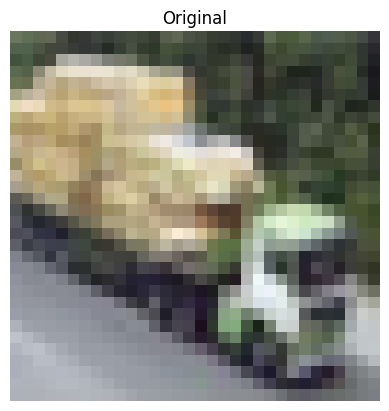

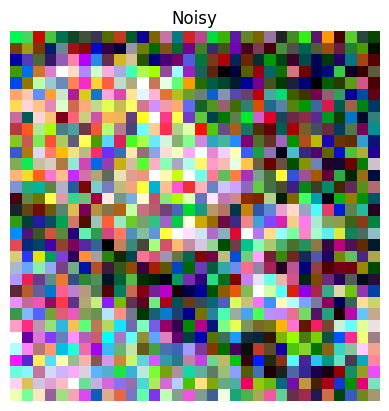

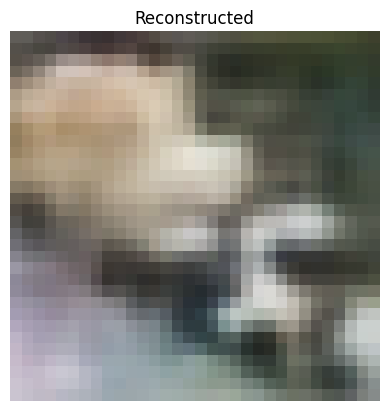

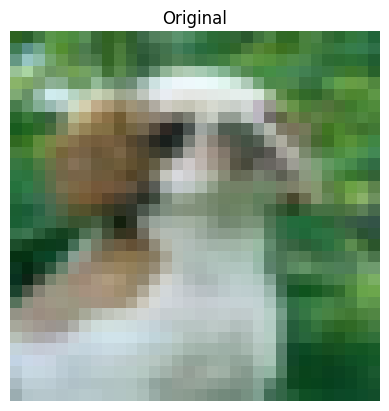

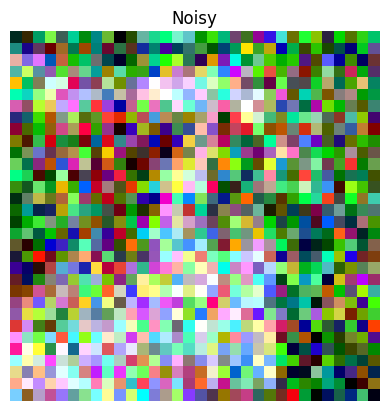

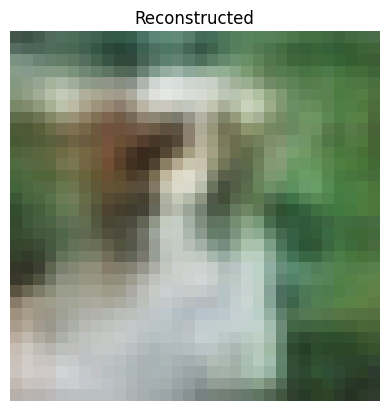

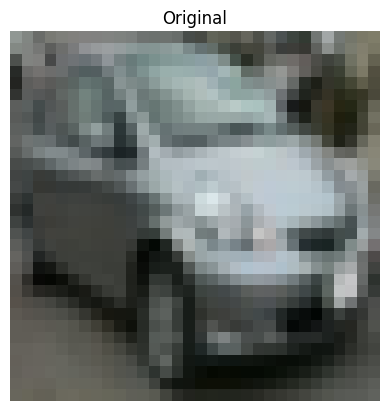

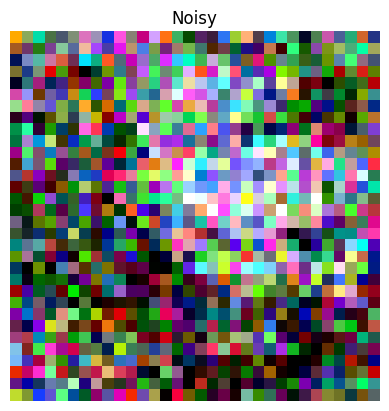

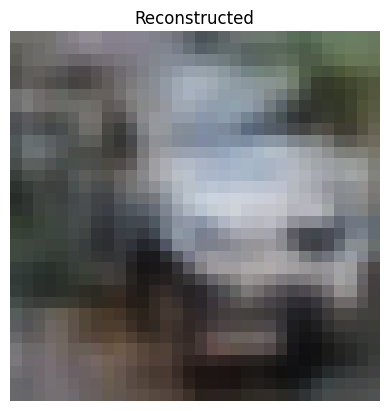

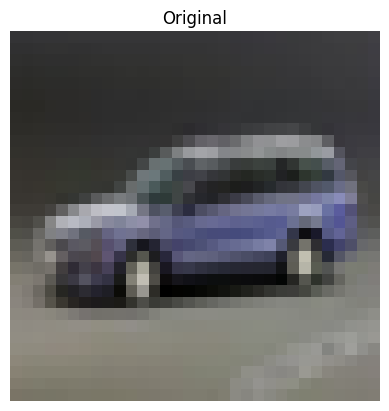

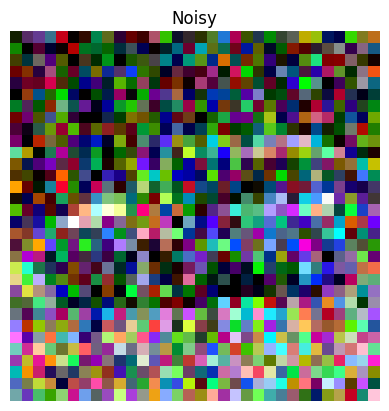

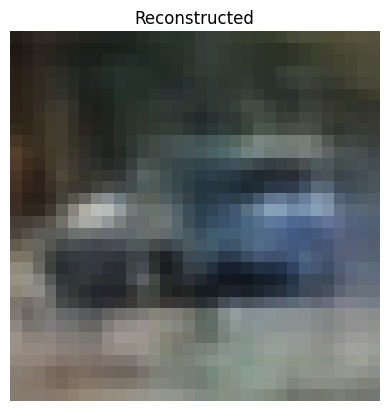

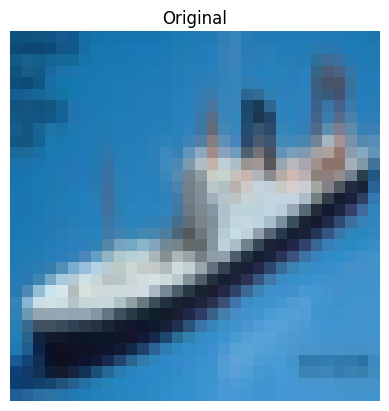

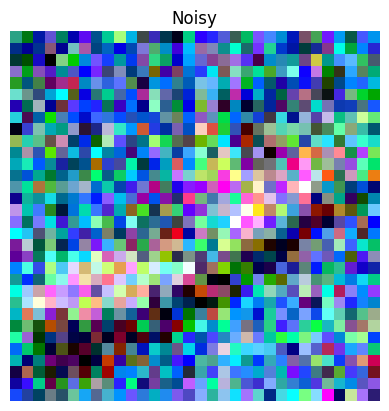

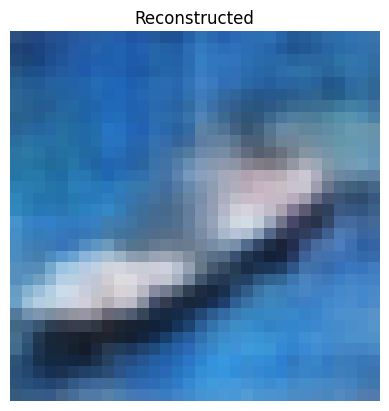

In [6]:
# Step 5: Visualize Outputs
def imshow(img, title=""):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

dataiter = iter(trainloader)
images, _ = next(dataiter)
noisy_imgs = add_noise(images)

images = images.to(device)
noisy_imgs = noisy_imgs.to(device)
model.eval()
with torch.no_grad():
    outputs = model(noisy_imgs)

# Show 5 samples
for i in range(5):
    imshow(torchvision.utils.make_grid(images[i].cpu()), "Original")
    imshow(torchvision.utils.make_grid(noisy_imgs[i].cpu()), "Noisy")
    imshow(torchvision.utils.make_grid(outputs[i].cpu()), "Reconstructed")


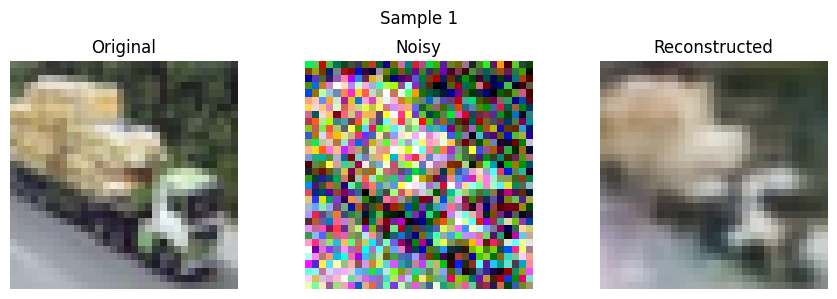

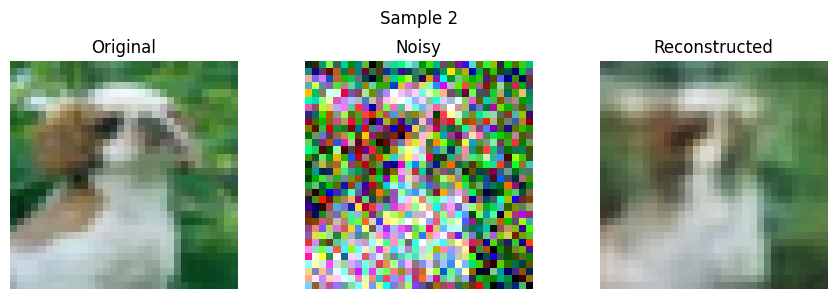

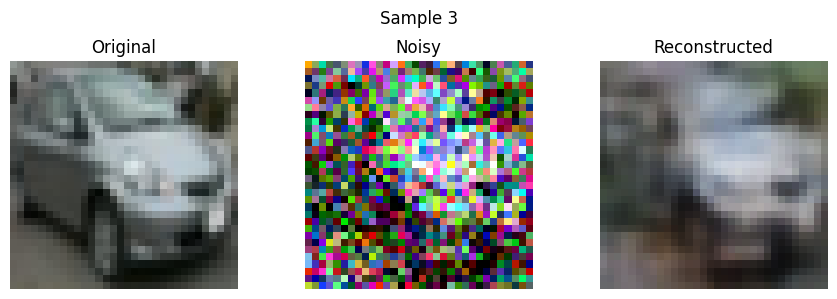

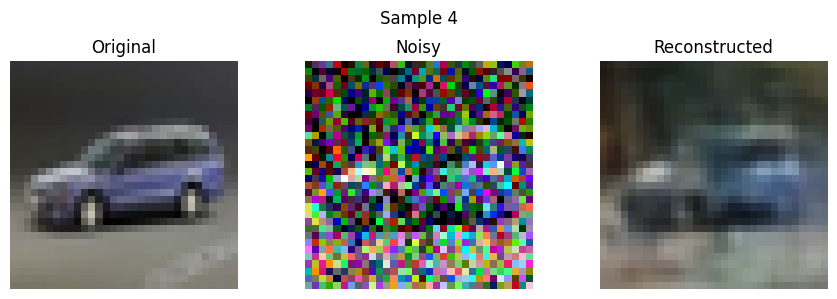

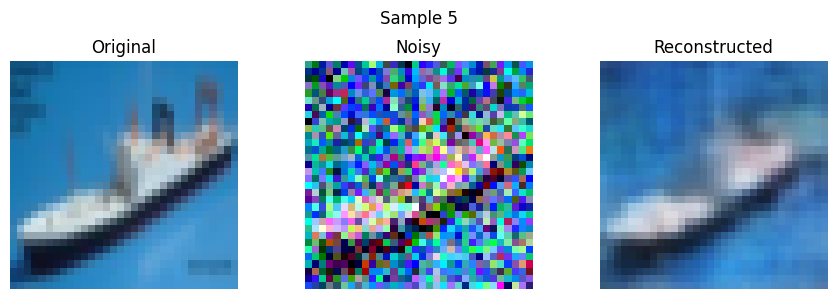

In [7]:
# Helper to show all three together
def show_side_by_side(original, noisy, output, idx):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    titles = ["Original", "Noisy", "Reconstructed"]
    imgs = [original, noisy, output]

    for i, ax in enumerate(axes):
        img = imgs[i].detach().cpu().permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(titles[i])
        ax.axis('off')
    plt.suptitle(f"Sample {idx}")
    plt.tight_layout()
    plt.show()

# Show 5 examples side by side
for i in range(5):
    show_side_by_side(images[i], noisy_imgs[i], outputs[i], i+1)
